In [6]:
# Create a function to fetch the stock data based on the ticker
def get_stock_data(ticker, years=1):
    start_date=(datetime.datetime.today() - datetime.timedelta(days=365*years)).strftime('%Y-%m-%d')
    end_date=datetime.datetime.today().strftime('%Y-%m-%d')
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [7]:
import dash 
from dash import dcc, html, Input, Output, dash_table 
import dash_bootstrap_components as dbc
import datetime as datetime
from dash.dependencies import Input, Output, State
import yfinance as yf
import requests  # To fetch data from an external API
import os

# Replace 'YOUR_API_KEY' with your actual NewsAPI key
news_api_key = os.environ.get('NEWS_API_KEY')

start_date = (datetime.datetime.today() - datetime.timedelta(days=365)).strftime('%Y-%m-%d')
end_date = datetime.datetime.today().strftime('%Y-%m-%d')
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.H1("Stock Performance Dashboard"),
        ]),
    ]),
    dbc.Row([
        dbc.Col([
            dcc.Input(
                id='stock-input',
                type='text',
                placeholder='Enter a stock symbol...',
                debounce=True,
                style={'width': '100%'}
            ),
        ], width=4),
        dbc.Col([
            dcc.Dropdown(
                id='stock-dropdown',
                multi=True,
                placeholder='Selected stocks...',
                style={'width': '100%'}
            ),
        ], width=4),
        dbc.Col([
            dcc.DatePickerRange(
                id='date-picker',
                start_date=start_date,
                end_date=end_date,
                display_format='YYYY-MM-DD'
            ),
        ], width=4),
    ]),
    dbc.Row([
        dbc.Col([
            dcc.Graph(id='stock-graph')
        ]),
    ]),
], fluid=True)

def fetch_stock_news(symbol, start_date, end_date):
    """
    Fetches significant news articles for a given stock symbol using NewsAPI.
    """
    url = f"https://newsapi.org/v2/everything?q={symbol}&from={start_date}&to={end_date}&sortBy=publishedAt&apiKey={news_api_key}"
    response = requests.get(url)
    articles = response.json().get('articles', [])

    # Process articles to create events with date, title, and description
    events = []
    for article in articles:
        # Ensure the article has a published date
        if 'publishedAt' in article:
            event_date = article['publishedAt'][:10]  # Extract date in 'YYYY-MM-DD' format
            events.append({
                'date': event_date,
                'event': article['title'],  # Use the article title as the event description
                'description': article['description']  # Use article description if needed
            })

    return events

@app.callback(
    Output('stock-dropdown', 'options'),
    Output('stock-dropdown', 'value'),
    Input('stock-input', 'value'),
    State('stock-dropdown', 'value'),
    State('stock-dropdown', 'options')
)
def update_dropdown(search_input, selected_symbols, existing_options):
    if not search_input:
        raise dash.exceptions.PreventUpdate

    # Initialize options if None
    if existing_options is None:
        existing_options = []

    # Fetch stock data from yfinance (or another API)
    try:
        stock_info = yf.Ticker(search_input).info
        stock_name = stock_info.get('longName', 'Unknown')
        option = {'label': f"{search_input.upper()} - {stock_name}", 'value': search_input.upper()}
        
        # Add new stock to options if not already present
        if option not in existing_options:
            existing_options.append(option)

        # Update selected symbols
        if selected_symbols is None:
            selected_symbols = []
        
        if search_input.upper() not in selected_symbols:
            selected_symbols.append(search_input.upper())
    except Exception as e:
        print(f"Error fetching stock info: {e}")
    
    return existing_options, selected_symbols

@app.callback(
    Output('stock-graph', 'figure'),
    Input('stock-dropdown', 'value'),
    Input('date-picker', 'start_date'),
    Input('date-picker', 'end_date')
)
def update_graph(selected_symbols, start_date, end_date):
    if not selected_symbols:
        return {'data': [], 'layout': {'title': 'Stock Closing Prices'}}

    data = []
    annotations = []  # List to hold annotations
    for symbol in selected_symbols:
        try:
            df = yf.download(symbol, start=start_date, end=end_date)
            if not df.empty:
                data.append({
                    'x': df.index, 
                    'y': df['Close'], 
                    'type': 'line', 
                    'name': symbol,
                    'hovertemplate': f"<b>{symbol}</b><br>Date: {{%{{x|%Y-%m-%d}}}}<br>Close: {{%{{y:.2f}}}}<extra></extra>"
                })

                # Fetch news dynamically using NewsAPI
                events = fetch_stock_news(symbol, start_date, end_date)
                for event in events:
                    event_date = event['date']
                    if event_date in df.index:  # Ensure the event date is within the fetched data
                        annotations.append({
                            'x': event_date, 
                            'y': df.loc[event_date]['Close'],
                            'xref': 'x', 
                            'yref': 'y',
                            'text': event['event'],
                            'showarrow': True, 
                            'arrowhead': 2, 
                            'ax': -40, 
                            'ay': -30
                        })
            else:
                print(f"No data found for {symbol} in the specified date range.")
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")

    # Update the layout with hovermode and annotations
    layout = {
        'title': 'Stock Closing Prices',
        'hovermode': 'x unified',
        'annotations': annotations  # Include annotations in the layout
    }

    return {'data': data, 'layout': layout}

if __name__ == '__main__':
    app.run_server(debug=True)

In [23]:
import yfinance as yf
import datetime
import pytz
import mplfinance as mpf
import ta

def get_stock_data(ticker, start_date, end_date, interval='1m'):
    # Convert string dates to datetime.date objects
    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d').date()

    # Define the timezone
    eastern = pytz.timezone('US/Eastern')

    # Set the start and end dates to 9:30 am and 4:00 pm Eastern time
    start_date = eastern.localize(datetime.datetime.combine(start_date, datetime.time(9, 30)))
    end_date = eastern.localize(datetime.datetime.combine(end_date, datetime.time(16, 0)))

    # Fetch the data
    df = yf.download(tickers=ticker, start=start_date, end=end_date, interval=interval)
    df['EMA_9'] = df['Close'].ewm(span=9, adjust=False).mean()
    df['EMA_15'] = df['Close'].ewm(span=15, adjust=False).mean()
    df['EMA_65'] = df['Close'].ewm(span=65, adjust=False).mean()
    df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()
    
    # Calculate RSI
    df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()

    return df

def plot_candlestick(df, ticker):
    apds = [
        mpf.make_addplot(df['EMA_9'], color='cyan', width=1.0, label='EMA 9'),
        mpf.make_addplot(df['EMA_15'], color='red', width=1.0, label='EMA 15'),
        mpf.make_addplot(df['EMA_65'], color='green', width=1.0, label='EMA 65'),
        mpf.make_addplot(df['EMA_200'], color='#d4af37', width=1.0, label='EMA 200'),
        mpf.make_addplot(df['RSI'], panel=2, color='blue', width=1.0, label='RSI')
    ]

    title = f'{ticker} Stock Price and EMAs \n[{df.index[0].strftime("%Y-%m-%d %H:%M:%S")} - {df.index[-1].strftime("%Y-%m-%d %H:%M:%S")}]'
    mpf.plot(df, type='candle', style='charles', title=title, ylabel='Price',
            addplot=apds, 
            show_nontrading=True, 
            volume=True, 
            figscale=1.2, 
            figratio=(16,9), 
            tight_layout=True, 
            volume_panel=1,
            )

In [29]:
df = get_stock_data(ticker='AAPL', 
                        interval='1m', 
                        start_date = '2024-09-19', 
                        end_date = '2024-09-19')
df.head(20)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,EMA_9,EMA_15,EMA_65,EMA_200,RSI
Datetime,,,,,,,,,,,
2024-09-19 09:30:00-04:00,224.940002,224.940002,224.940002,224.940002,224.940002,0,224.940002,224.940002,224.940002,224.940002,NaN
2024-09-19 09:31:00-04:00,224.880005,225.092697,224.639999,225.020004,225.020004,260403,224.956003,224.950003,224.942427,224.940798,NaN
2024-09-19 09:32:00-04:00,225.080002,225.380005,224.970001,225.339996,225.339996,452089,225.032802,224.998752,224.954474,224.944771,NaN
2024-09-19 09:33:00-04:00,225.339996,225.690002,225.250000,225.649994,225.649994,338875,225.156240,225.080157,224.975551,224.951788,NaN
2024-09-19 09:34:00-04:00,225.699997,226.089996,225.699997,225.949997,225.949997,493739,225.314991,225.188887,225.005079,224.961720,NaN
2024-09-19 09:35:00-04:00,225.949997,226.029907,225.399994,225.698502,225.698502,306565,225.391693,225.252589,225.026092,224.969051,NaN
2024-09-19 09:36:00-04:00,225.710007,226.197205,225.490005,226.030106,226.030106,374735,225.519376,225.349779,225.056517,224.979609,NaN
2024-09-19 09:37:00-04:00,226.037994,226.410004,226.013596,226.300003,226.300003,311559,225.675501,225.468557,225.094198,224.992747,NaN
2024-09-19 09:39:00-04:00,226.479996,226.520004,226.380005,226.410004,226.410004,654956,225.822402,225.586237,225.134071,225.006849,NaN


[*********************100%***********************]  1 of 1 completed


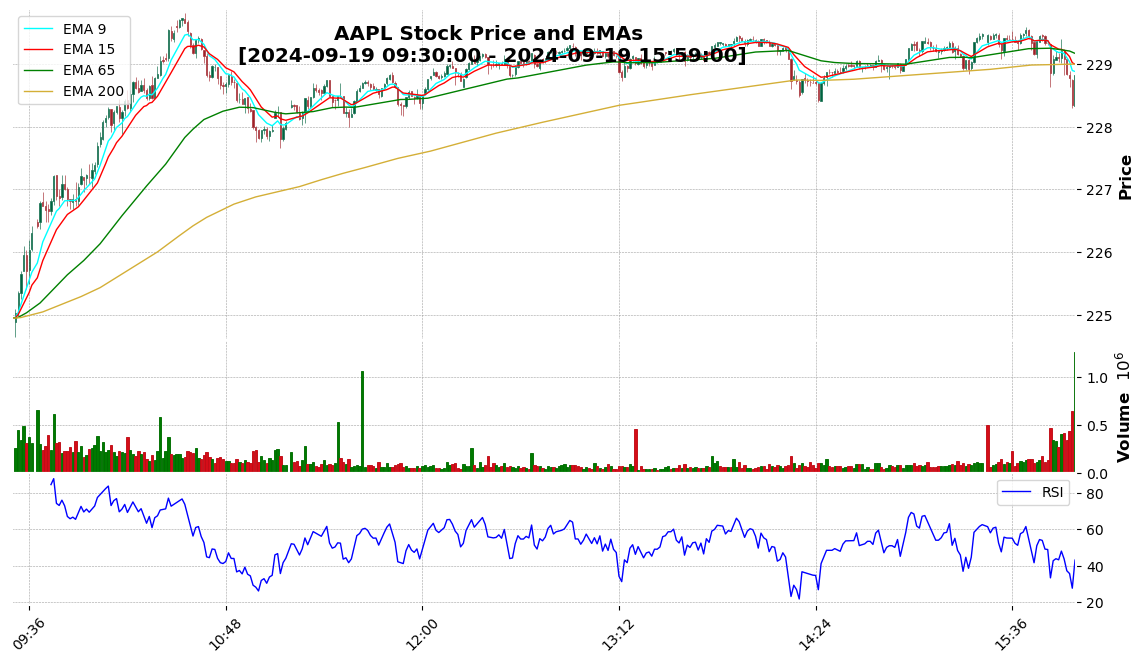

,Open,High,Low,Close,Adj Close,Volume,EMA_9,EMA_15,EMA_65,EMA_200,RSI
Datetime,,,,,,,,,,,
2024-09-19 09:30:00-04:00,224.940002,224.940002,224.940002,224.940002,224.940002,0,224.940002,224.940002,224.940002,224.940002,NaN
2024-09-19 09:31:00-04:00,224.880005,225.092697,224.639999,225.020004,225.020004,260403,224.956003,224.950003,224.942427,224.940798,NaN
2024-09-19 09:32:00-04:00,225.080002,225.380005,224.970001,225.339996,225.339996,452089,225.032802,224.998752,224.954474,224.944771,NaN
2024-09-19 09:33:00-04:00,225.339996,225.690002,225.250000,225.649994,225.649994,338875,225.156240,225.080157,224.975551,224.951788,NaN
2024-09-19 09:34:00-04:00,225.699997,226.089996,225.699997,225.949997,225.949997,493739,225.314991,225.188887,225.005079,224.961720,NaN


[*********************100%***********************]  1 of 1 completed


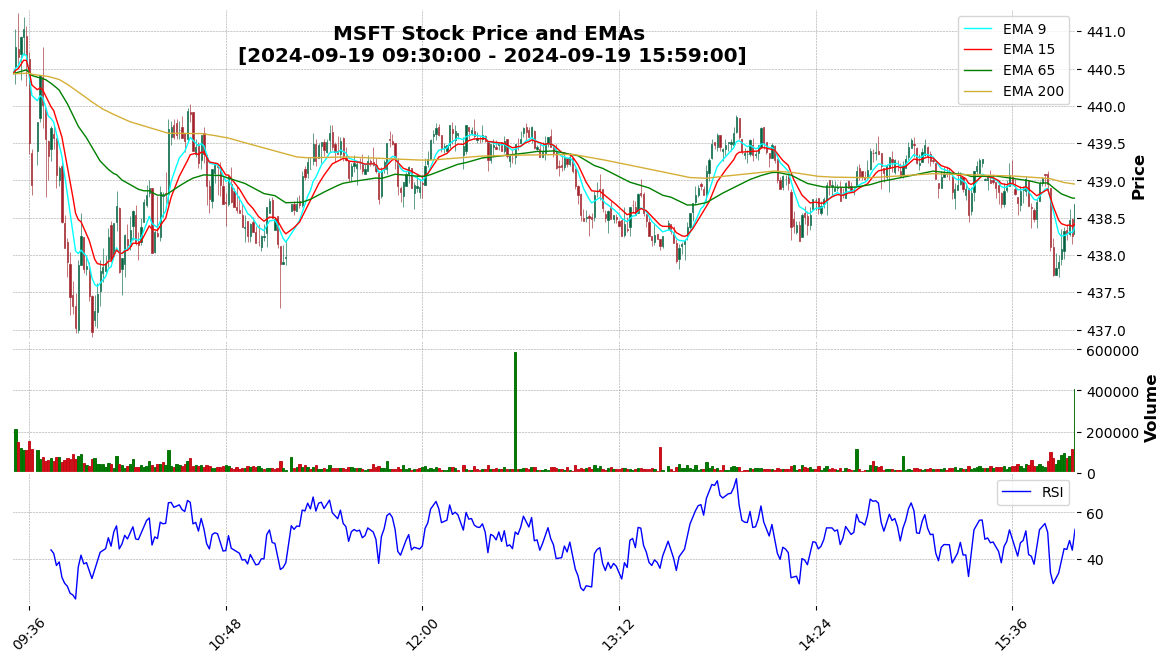

,Open,High,Low,Close,Adj Close,Volume,EMA_9,EMA_15,EMA_65,EMA_200,RSI
Datetime,,,,,,,,,,,
2024-09-19 09:30:00-04:00,440.429993,440.429993,440.429993,440.429993,440.429993,0,440.429993,440.429993,440.429993,440.429993,NaN
2024-09-19 09:31:00-04:00,440.516388,441.029999,440.295593,440.795013,440.795013,210952,440.502997,440.475620,440.441054,440.433625,NaN
2024-09-19 09:32:00-04:00,440.765015,441.250000,440.529999,440.660004,440.660004,147798,440.534398,440.498668,440.447689,440.435877,NaN
2024-09-19 09:33:00-04:00,440.700012,440.940002,440.350006,440.929993,440.929993,121249,440.613517,440.552584,440.462304,440.440794,NaN
2024-09-19 09:34:00-04:00,440.929993,441.190002,440.679993,441.024994,441.024994,110729,440.695812,440.611635,440.479355,440.446607,NaN


[*********************100%***********************]  1 of 1 completed


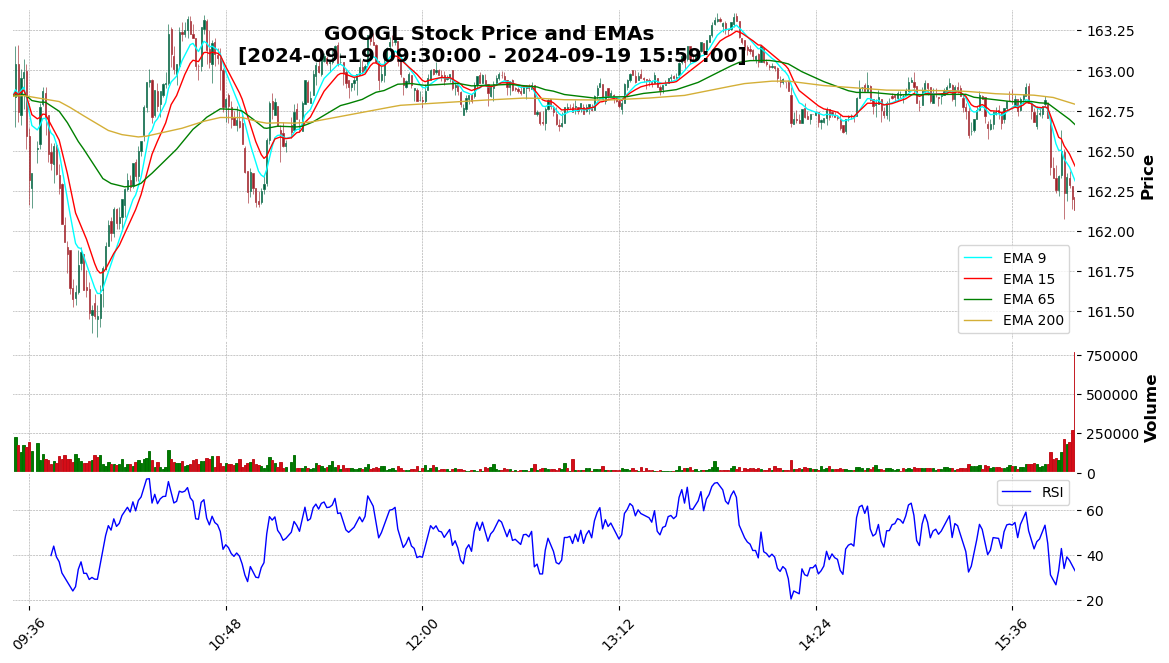

,Open,High,Low,Close,Adj Close,Volume,EMA_9,EMA_15,EMA_65,EMA_200,RSI
Datetime,,,,,,,,,,,
2024-09-19 09:30:00-04:00,162.839996,162.839996,162.839996,162.839996,162.839996,0,162.839996,162.839996,162.839996,162.839996,NaN
2024-09-19 09:31:00-04:00,162.835007,163.149994,162.649994,163.039993,163.039993,224121,162.879996,162.864996,162.846057,162.841986,NaN
2024-09-19 09:32:00-04:00,163.039993,163.160004,162.679993,162.740005,162.740005,173610,162.851998,162.849372,162.842843,162.840972,NaN
2024-09-19 09:33:00-04:00,162.720001,163.009995,162.660004,162.949997,162.949997,132594,162.871598,162.861950,162.846090,162.842056,NaN
2024-09-19 09:34:00-04:00,162.949997,163.070007,162.759995,162.990005,162.990005,174218,162.895279,162.877957,162.850451,162.843529,NaN


In [32]:
for ticker in ['AAPL', 'MSFT', 'GOOGL']:
    df = get_stock_data(ticker=ticker, 
                        interval='1m', 
                        start_date = '2024-09-19', 
                        end_date = '2024-09-19')
    plot_candlestick(df, ticker)
    display(df.head())

In [13]:
def fetch_stock_news(symbol, start_date, end_date):
    """
    Fetches significant news articles for a given stock symbol using NewsAPI.
    """
    url = f"https://newsapi.org/v2/everything?q={symbol}&from={start_date}&to={end_date}&sortBy=publishedAt&apiKey={news_api_key}"
    response = requests.get(url)
    print(f"NewsAPI Response Status: {response.status_code}")
    if response.status_code != 200:
        print("Error fetching news:", response.json())
        return []

    articles = response.json().get('articles', [])

    # Process articles to create events with date, title, and description
    events = []
    for article in articles:
        # Ensure the article has a published date
        if 'publishedAt' in article:
            event_date = article['publishedAt'][:10]  # Extract date in 'YYYY-MM-DD' format
            events.append({
                'date': event_date,
                'event': article['title'],  # Use the article title as the event description
                'description': article['description']  # Use article description if needed
            })

    print(f"Fetched {len(events)} events for symbol {symbol}")
    return events

In [3]:
print(start_date)
print(end_date)

2023-09-06
2024-09-05


In [15]:
news = fetch_stock_news('AAPL', start_date, end_date)
news

NewsAPI Response Status: 429
Error fetching news: {'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}


[]